In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_lfw_people,fetch_olivetti_faces
import matplotlib.pyplot as plt


In [41]:
def pca(X, k):
    # Standardize the data
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std = np.where(X_std == 0, 1, X_std)  # avoid division by zero
    X_std = (X - X_mean) / X_std

    # Compute the covariance matrix
    cov_matrix = np.cov(X_std.T)  #cov = A^T * A

    # Compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)   

    # Sort the eigenvalues and corresponding eigenvectors
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # Select the top k eigenvectors
    top_k_eigenvectors = eigenvectors[:, :k]

    #   mapping back to origincal dataset
    X_pca = np.dot(X_std, top_k_eigenvectors)
    print(X_pca.shape)

    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues[:k] / np.sum(eigenvalues)

    return X_pca, explained_variance_ratio, top_k_eigenvectors, X_mean, X_std

In [42]:
def pca_inverse_transform(X_pca, top_k_eigenvectors, X_mean, X_std):
    # Map back to the original space
    X_std_reconstructed = np.dot(X_pca, top_k_eigenvectors.T)

    # Unstandardize the data
    X_reconstructed = X_std_reconstructed * X_std + X_mean

    return X_reconstructed

In [43]:
# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# n_samples, h, w = lfw_people.images.shape
# X = lfw_people.data
# y = lfw_people.target
# target_names = lfw_people.target_names
# n_classes = target_names.shape[0]

olivetti_people = fetch_olivetti_faces()

# Get the shape of the images
n_samples, h, w = olivetti_people.images.shape

# Get the data
X = olivetti_people.data

# Get the target
y = olivetti_people.target

# Get the target names
target_names = np.array(["person_" + str(i) for i in range(40)])

# Get the number of classes
n_classes = target_names.shape[0]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape


(300, 4096)

In [45]:
# Compute PCA (eigenfaces) on the face dataset 
X_train_pca, explained_variance_ratio, top_k_eigenvectors, X_mean, X_std = pca(X_train, 150)
X_test_pca= pca(X_test, 150)



(300, 150)
(100, 150)


In [46]:
# Calculate the cumulative sum of explained variances


explained_variances = np.cumsum(explained_variance_ratio)


In [47]:
# Find the number of components that explain a certain percentage of the variance
n_components = [np.argmax(explained_variances >= 0.9) + 1 ]

In [48]:
# Select the top k eigenfaces, project the training set onto the eigenfaces, and reconstruct the images
X_reconstructed = pca_inverse_transform(X_train_pca, top_k_eigenvectors, X_mean, X_std)

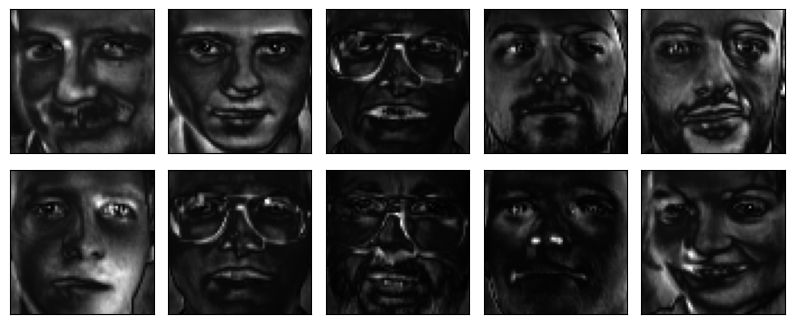

In [50]:

# Select the first 10 images from the array
first_10_images = X_reconstructed[:10]

fig, axes = plt.subplots(2, 5, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    # Reshape the image to its original 2D shape
    # Replace 'height' and 'width' with the actual dimensions of your images
    image_2D = first_10_images[i].reshape((h, w))
    image_2D_real = image_2D.real


    # Display the image
    ax.imshow(image_2D_real, cmap='gray')

plt.show()